# Microstructure characterization of battery materials based on voxelated image data: Computation of active surface area and tortuosity

## Second validation example: FCC structure

<div class="row">
  <div class="col-md-7" markdown="1">
  This validation increases the complexity of the first example by adding contact between spherical bodies while the volume fraction and surface area can still be expressed analytically as a function of the unit cell side length. This validation is well suited as
<ul>
  <li>the surface is analytically known,</li>
  <li>the example is 3D but yet simple,</li>
  <li>the surface is curved and, thus, will suffer from pixelation issues</li>
  <li>the example can be used to compute tortuosity in the solid and the pore space.</li>
</ul>
<br>
Without a defined overlap, a voxelization issue arises where for all configurations with an even number of voxels per cube length the spheres are touching at voxel edges while for all odd configurations the spheres are fully connected. This can be seen in the front view of the cube:
  </div>
  <div class="col-md-5" markdown="1">
  <img src="data-paper/fcc-study/fcc_solid_3D.png" alt="Image 1" width="220" />
  </div>
</div>
<br>

<div class="row">
<div class="col-md-2" markdown="1">
  <img src="data-paper/fcc-study/fcc_10_pure.png" alt="Image 1" width="100" />
</div>
<div class="col-md-2" markdown="1">
  <img src="data-paper/fcc-study/fcc_11_pure.png" alt="Image 1" width="100" />
</div>
<div class="col-md-2" markdown="1">
  <img src="data-paper/fcc-study/fcc_50_pure.png" alt="Image 1" width="100" />
</div>
<div class="col-md-2" markdown="1">
  <img src="data-paper/fcc-study/fcc_51_pure.png" alt="Image 1" width="100" />
</div>
<div class="col-md-2" markdown="1">
  <img src="data-paper/fcc-study/fcc_100_pure.png" alt="Image 1" width="100" />
</div>
<div class="col-md-2" markdown="1">
  <img src="data-paper/fcc-study/fcc_101_pure.png" alt="Image 1" width="100" />
</div>
</div>
<div class="row">
<div class="col-md-2" markdown="1">
  $10^3$ voxels 
</div>
<div class="col-md-2" markdown="1">
  $11^3$ voxels
</div>
<div class="col-md-2" markdown="1">
  $50^3$ voxels
</div>
<div class="col-md-2" markdown="1">
  $51^3$ voxels
</div>
<div class="col-md-2" markdown="1">
  $100^3$ voxels
</div>
<div class="col-md-2" markdown="1">
  $101^3$ voxels
</div>
</div>


**Author**: Simon Daubner<br>
**Department**: Department of Mechanical Engineering<br>
**Institution**: Karlsruhe Institute of Technology

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import taufactor.metrics as tau

import metrics
import data
import time

We initialize the grid resolution as

In [4]:
dx = 1.0
dy = dx

In [5]:
#%%capture

# ADD Profiling!!
fcc_results = {}
overlaps = [0.0] #[0.0,0.01,0.05,0.1,0.2]

for overlap in overlaps:
    # resolution = [6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,50,51,100,101,200,201,300,301,400,401]
    resolution = [100]
    
    # Initialize fields
    fcc_vol_fraction = {'theo':np.zeros(len(resolution)),
                        'num':np.zeros(len(resolution))}

    methods = ['theo', 'faces', 'marching', 'conv_marching', 'porespy', 'gradient', 'conv_gradient']
    area = {method: np.zeros(len(resolution)) for method in methods}
    times = {method: np.zeros(len(resolution)) for method in methods[1:]}
    
    connectivity_type = ['s_side', 's_edge', 's_corner', 'p_side', 'p_edge', 'p_corner']
    connectivity = {conn: np.zeros(len(resolution)) for conn in connectivity_type}
    tortuosity   = {'solid': np.zeros(len(resolution)),
                    'pore': np.zeros(len(resolution))}
    
    for i, pixels in enumerate(resolution):
        sharp_field = data.create_fcc_cube(pixels, overlap=overlap)
        vol, surf = data.theoretical_fcc_metrics(pixels, overlap)
                        
        fcc_vol_fraction['theo'][i] = vol
        fcc_vol_fraction['num'][i] = metrics.volume_fraction(sharp_field, 1)
        
        timer=[]
        area['theo'][i] = surf
        timer.append(time.time())
        area['faces'][i] = 3*tau.surface_area(sharp_field, phases=[1]).item()
        timer.append(time.time())
        area['marching'][i] = metrics.specific_surface_area_marching(sharp_field)
        timer.append(time.time())
        phase_field = metrics.smooth_with_convolution(sharp_field)
        area['conv_marching'][i] = metrics.specific_surface_area_marching(phase_field)
        timer.append(time.time())
        area['porespy'][i]  = metrics.specific_surface_area_porespy(sharp_field)
        timer.append(time.time())
        area['gradient'][i] = metrics.specific_surface_area(sharp_field)
        timer.append(time.time())
        area['conv_gradient'][i] = metrics.specific_surface_area(sharp_field, smooth=1)
        timer.append(time.time())
        
        for k, method in enumerate(methods[1:]):
            times[method][i] = np.array(timer)[k+1]-np.array(timer)[k]
        
        # Compute through feature and tortuosity
        #through_feature, through_fraction = metrics.extract_through_feature(sharp_field, 1, 'x')
        #connectivity['s_side'][i] = through_fraction[0]
        #connectivity['s_edge'][i] = through_fraction[1]
        #connectivity['s_corner'][i] = through_fraction[2]
        
        #if through_fraction[0]>0.0:
        #    res = metrics.tortuosity(through_feature[0])
        #    if res<1000: tortuosity['solid'][i] = res
        #    
        #through_feature, through_fraction = metrics.extract_through_feature(sharp_field, 0, 'x')
        #connectivity['p_side'][i] = through_fraction[0]
        #connectivity['p_edge'][i] = through_fraction[1]
        #connectivity['p_corner'][i] = through_fraction[2]
        
        #if through_fraction[0]>0.0:
        #    res = metrics.tortuosity(through_feature[0])
        #    if res<1000: tortuosity['pore'][i] = res
        
        print(f"Finished FCC with {pixels}^3 voxels.")
        
    fcc_results[f'overlap{int(100*overlap)}'] = {'vol':fcc_vol_fraction,
                                                 'area':area,
                                                 'time':times,
                                                 'connected':connectivity,
                                                 'taufactor':tortuosity}

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/simond/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_22843/2892435972.py", line 23, in <module>
    sharp_field = data.create_fcc_cube(pixels, overlap=overlap)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/simond/workspace/micro-characterization/data.py", line 85, in create_fcc_cube
    add_voxel_sphere(cube, *corner, radius)
  File "/home/simond/workspace/micro-characterization/data.py", line -1, in add_voxel_sphere
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/simond/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2102, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/simond/a

### Plotting
Plot the results based on following color and line style

In [26]:
colors = ['black', 'red', 'blue', 'purple', 'orange', 'lime', 'green', 'black']
line_styles = ['-', '-.', ':', ':', '--', '-', '-.','-']

Plot relative volume error

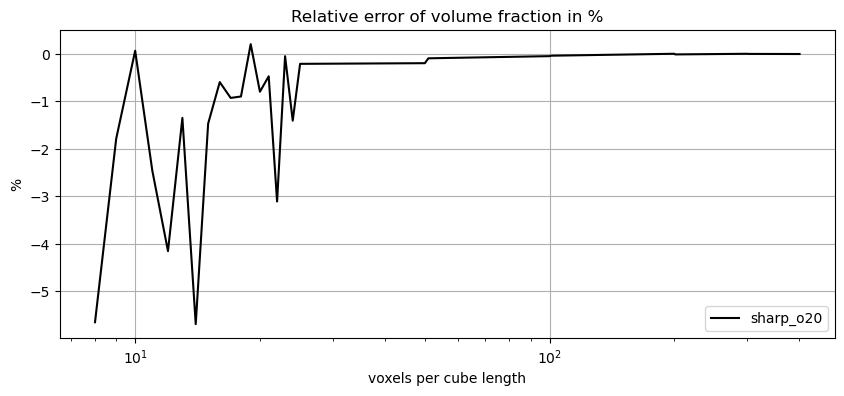

In [27]:
fig, ax = plt.subplots(figsize=(10, 4))
for i, o in enumerate(overlaps):
    ax.semilogx(resolution, (fcc_results[f'overlap{int(100*o)}']['vol']['num']-fcc_results[f'overlap{int(100*o)}']['vol']['theo'])/fcc_results[f'overlap{int(100*o)}']['vol']['theo']*100, label=f'sharp_o{int(100*o)}', color=colors[i], linestyle=line_styles[i])

ax.set_xlabel('voxels per cube length')
ax.set_ylabel('%')
ax.set_title('Relative error of volume fraction in %')
ax.legend()
ax.grid()
plt.show()

Relative error of surface area computation

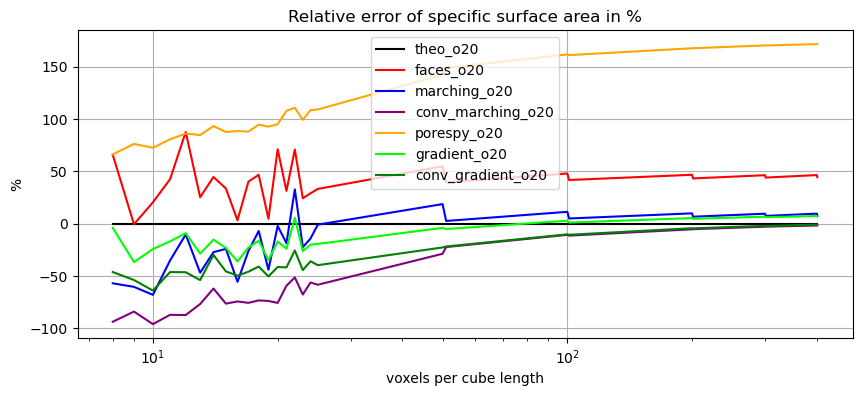

In [28]:
fig, ax = plt.subplots(figsize=(10, 4))
for i, o in enumerate(overlaps):
    for j, method in enumerate(methods):
        rel_error = (fcc_results[f'overlap{int(100*o)}']['area'][method]-fcc_results[f'overlap{int(100*o)}']['area']['theo'])/fcc_results[f'overlap{int(100*o)}']['area']['theo']*100
        ax.semilogx(resolution, rel_error, label=method+f'_o{int(100*o)}', color=colors[j], linestyle=line_styles[i])

ax.set_xlabel('voxels per cube length')
ax.set_ylabel('%')
ax.set_title('Relative error of specific surface area in %')
ax.legend()
ax.grid()

plt.show()

And, last but not least, the computation times

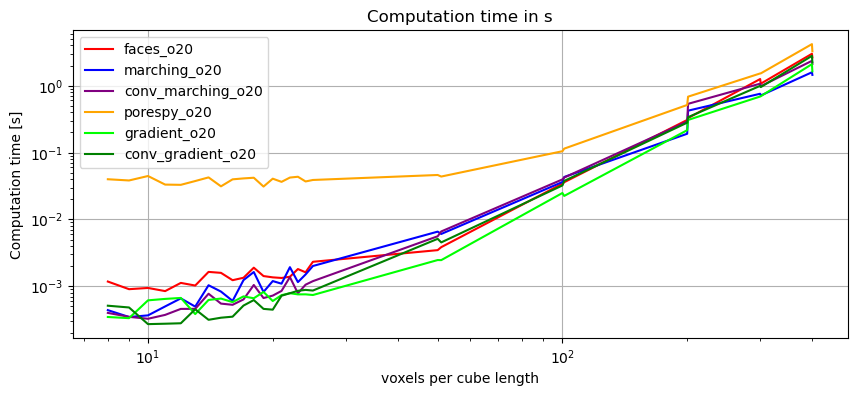

In [29]:
fig, ax = plt.subplots(figsize=(10, 4))
for i, o in enumerate(overlaps):
    for j, method in enumerate(methods[1:]):
        ax.loglog(resolution, fcc_results[f'overlap{int(100*o)}']['time'][method], label=method+f'_o{int(100*o)}', color=colors[j+1], linestyle=line_styles[i])

ax.set_xlabel('voxels per cube length')
ax.set_ylabel('Computation time [s]')
ax.set_title('Computation time in s')
ax.legend()
ax.grid()

plt.show()

### Save results to text file
Define a file name and write results dictionary as text table

In [31]:
file_name = "fcc_overlap20.txt"
output = {'pixels':resolution}
buffer = fcc_results['overlap20']
for key,s in buffer['vol'].items():
    header = 'vol_'+key
    output[header] = s
for key,s in buffer['area'].items():
    header = 'a_'+key
    output[header] = s
for key,s in buffer['time'].items():
    header = 't_'+key
    output[header] = s
for key,s in buffer['connected'].items():
    header = 'con_'+key
    output[header] = s
for key,s in buffer['taufactor'].items():
    header = 'tau_'+key
    output[header] = s

data.write_dict_to_txt(output, file_name)
print(f"Data written to {file_name}.")

Data written to fcc_overlap20.txt.
